# Introduction

Why do we like certain beers and not others? What makes a beer good an what makes a beer bad? And most importantly, can we predict how much we will like a beer based on its characteristics? These are the questions we will try to answer in this notebook. We will work with two very exciting datasets that contain taste information about a wide range of craft beers and their reviews on the popular website BeerAdvocate.com. 

The first dataset contains ~1.5 million reviews of beers from the website BeerAdvocate.com . The second dataset contains taset information from the reviews on BeerAdvocate.com that contain the flavour profiles of the beers (retrieved here: https://www.kaggle.com/datasets/stephenpolozoff/top-beer-information). Using fuzzy matching (shown in the script "datamatching.py"), we have matched the two datasets and can now work with a complete dataset that contains taset information of over 3000 beers and their (aggregated) review scores. 

Ultimately, we will try to predict the review score of a beer based on its taste characteristics. We will use a variety of machine learning algorithms to do so, including linear regression, random forest, gradient boosting, and neural networks. To do so, we will first explore the data to better understand how taste notes relate to beer review scores. We will then use the taste notes to predict the review score of a beer. After that, we will try to use hyperparameter tuning to improve the performance of the model that we have chosen.

First, we will import the necessary libraries and load the data.

In [1]:
# Load libraries
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import the dataset
data = pd.read_csv('data/beer_profile_and_ratings.csv')

What data are we working with?

In [16]:
# show the head of the data
print(data.head())

# drop all beers with less than 5 reviews
data = data[data['number_of_reviews'] >= 5]

                           Name    Style  \
0                         Amber  Altbier   
1                    Double Bag  Altbier   
2                Long Trail Ale  Altbier   
3                  Doppelsticke  Altbier   
4  Sleigh'r Dark Doüble Alt Ale  Altbier   

                                            Brewery  \
0                               Alaskan Brewing Co.   
1                            Long Trail Brewing Co.   
2                            Long Trail Brewing Co.   
3  Uerige Obergärige Hausbrauerei GmbH / Zum Uerige   
4                           Ninkasi Brewing Company   

                                    Beer Name (Full)  \
0                  Alaskan Brewing Co. Alaskan Amber   
1                  Long Trail Brewing Co. Double Bag   
2              Long Trail Brewing Co. Long Trail Ale   
3  Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...   
4  Ninkasi Brewing Company Sleigh'r Dark Doüble A...   

                                         Description  ABV  Min IBU 

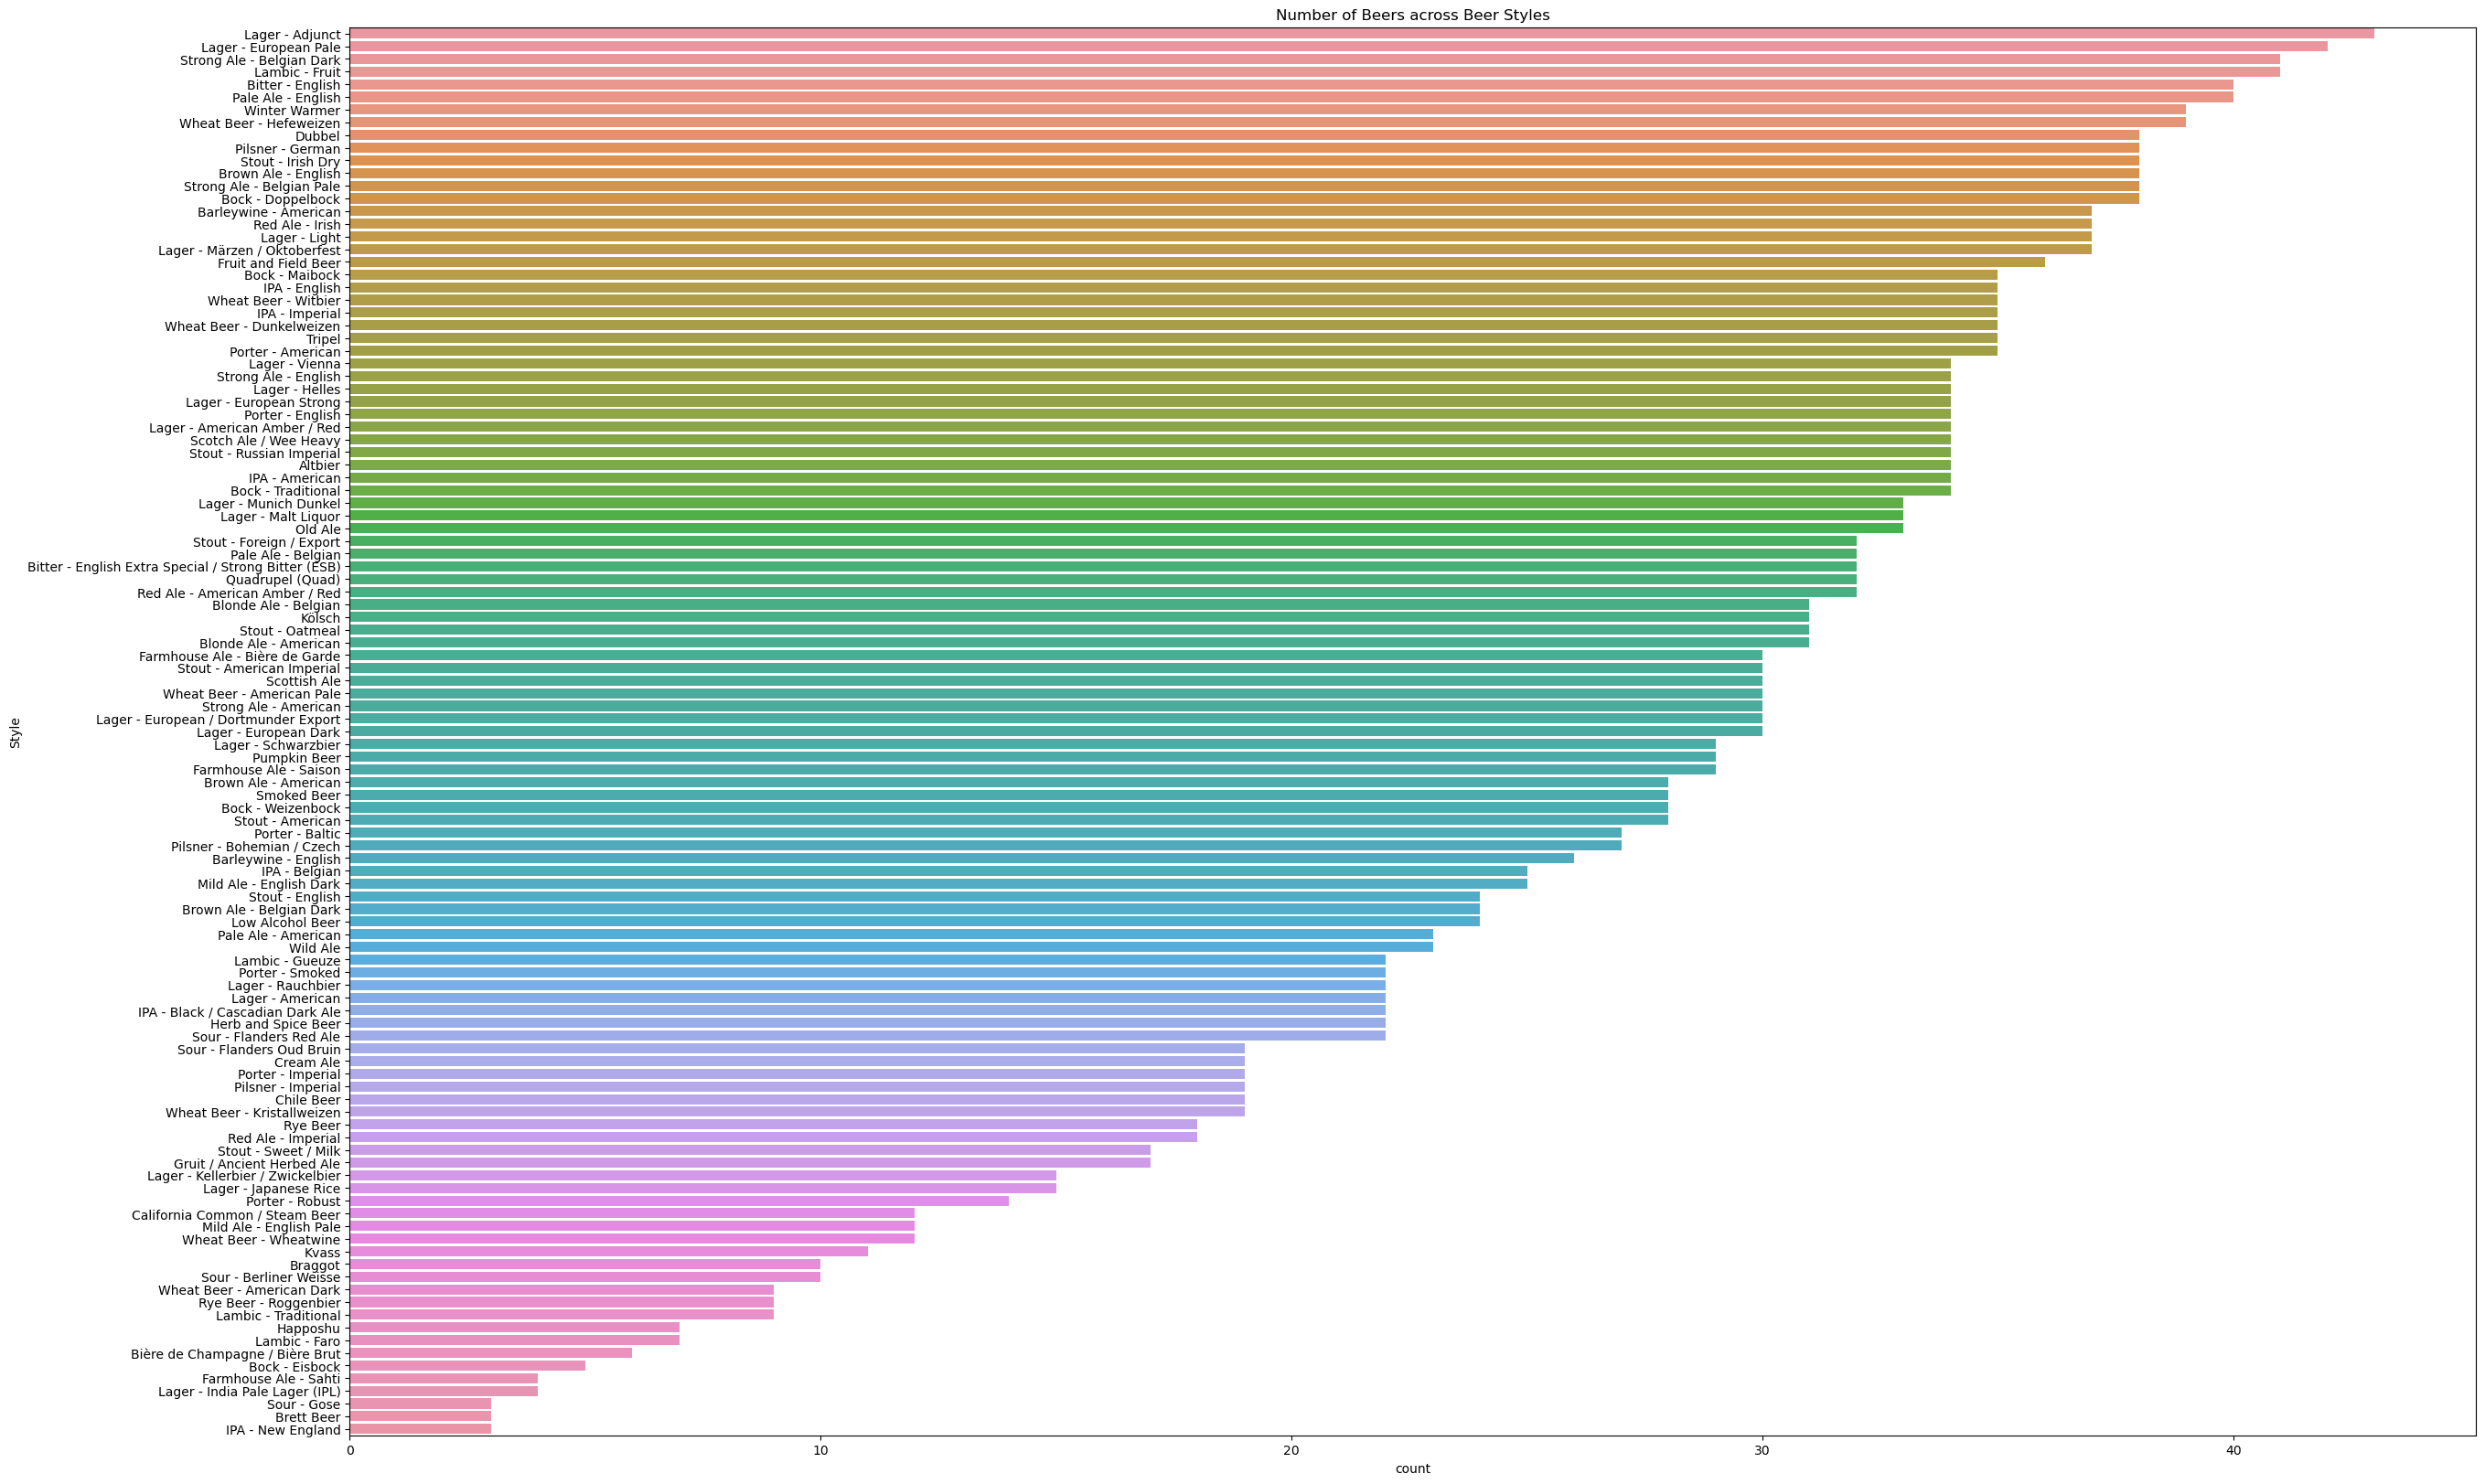

c:\Users\motru\Anaconda3\envs\projectVenv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 142 (\x8e) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


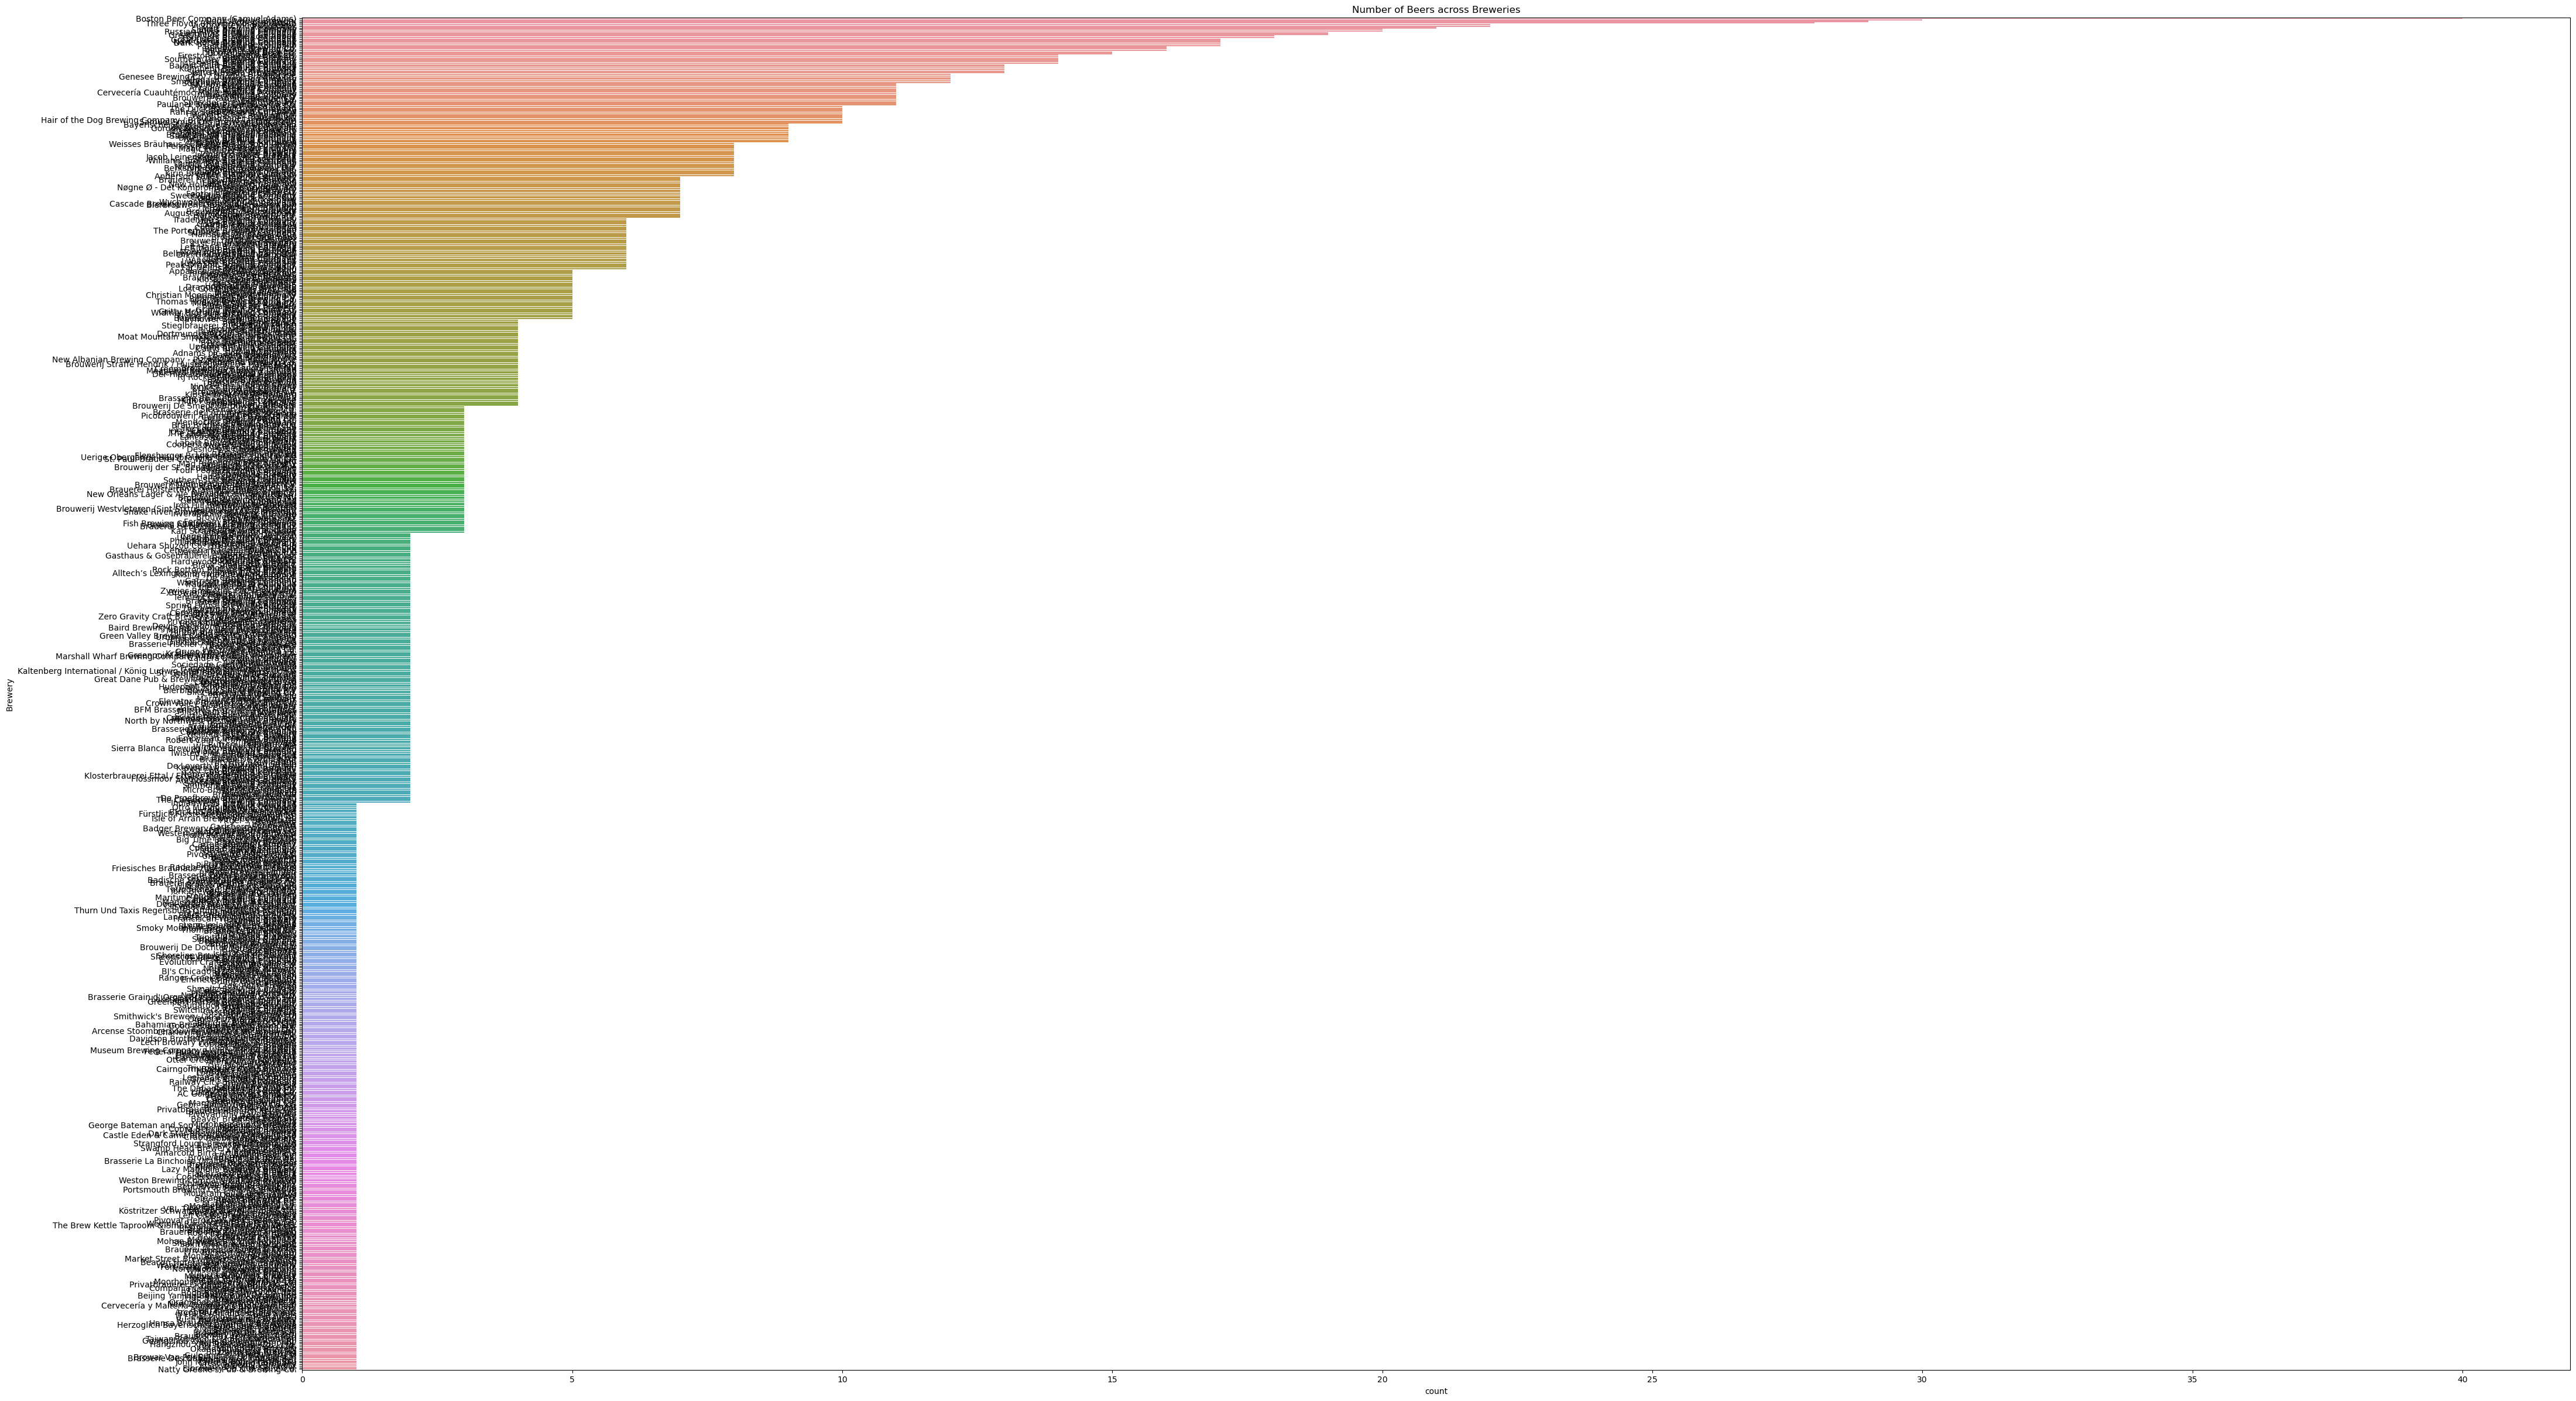

<Figure size 2000x1000 with 0 Axes>

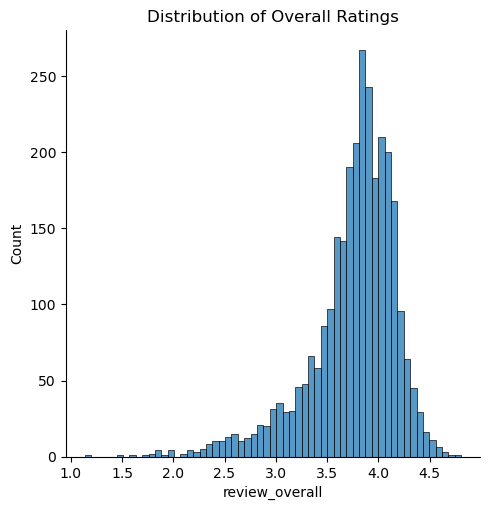

In [3]:
# Check the distribution of observations across beer styles and breweries
# what is the distribution of number of beers across beer Style?
plt.figure(figsize=(30, 20))
sns.countplot(y='Style', data=data, order=data.Style.value_counts().index)
plt.title('Number of Beers across Beer Styles')
plt.show()  # linear distribution

# what is the distribution of number of beers across Breweries?
plt.figure(figsize=(50, 30))
sns.countplot(y='Brewery', data=data, order=data.Brewery.value_counts().index)
plt.title('Number of Beers across Breweries')
plt.show()  # log distribution

# what is the distribution of overall reviews?
plt.figure(figsize=(20, 10))
sns.displot(data['review_overall'], kde=False)
plt.title('Distribution of Overall Ratings')
plt.show()  # people are very critical! The highest rating in the data is a beer with 4.8/5


<Figure size 2000x1000 with 0 Axes>

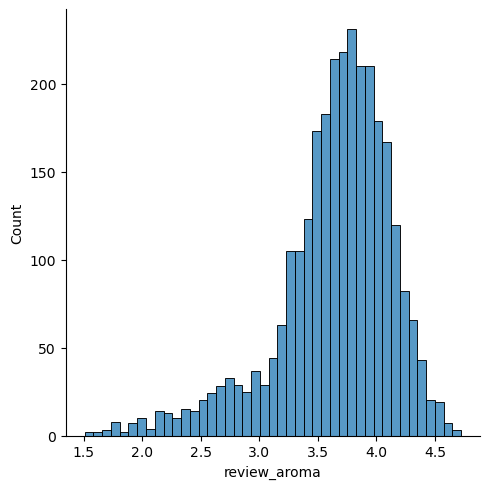

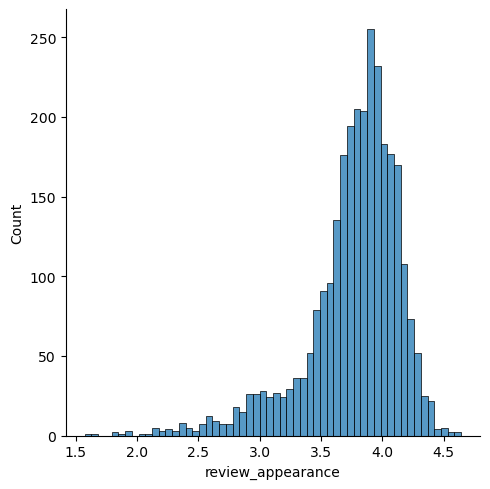

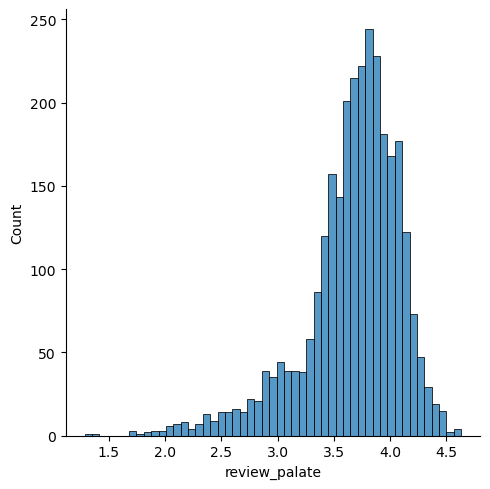

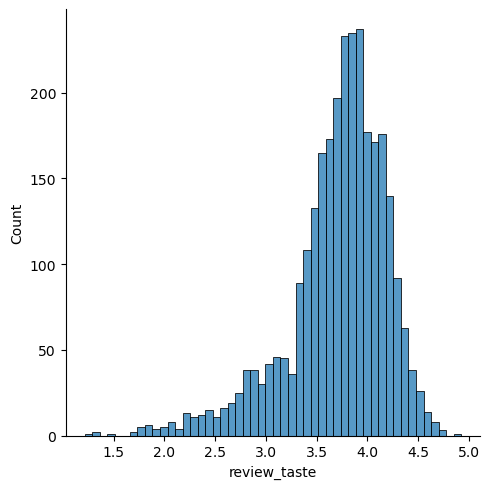

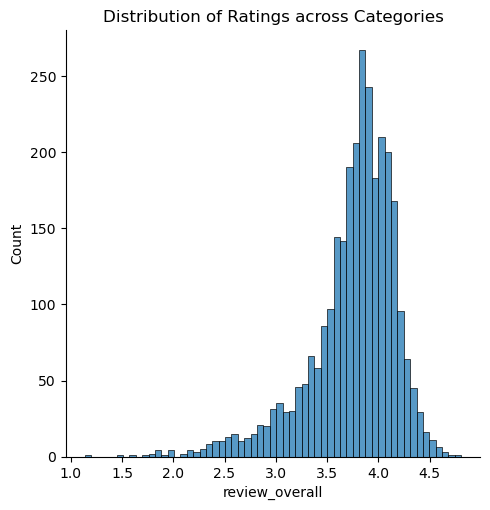

Text(0.5, 1.0, 'Correlation between Ratings')

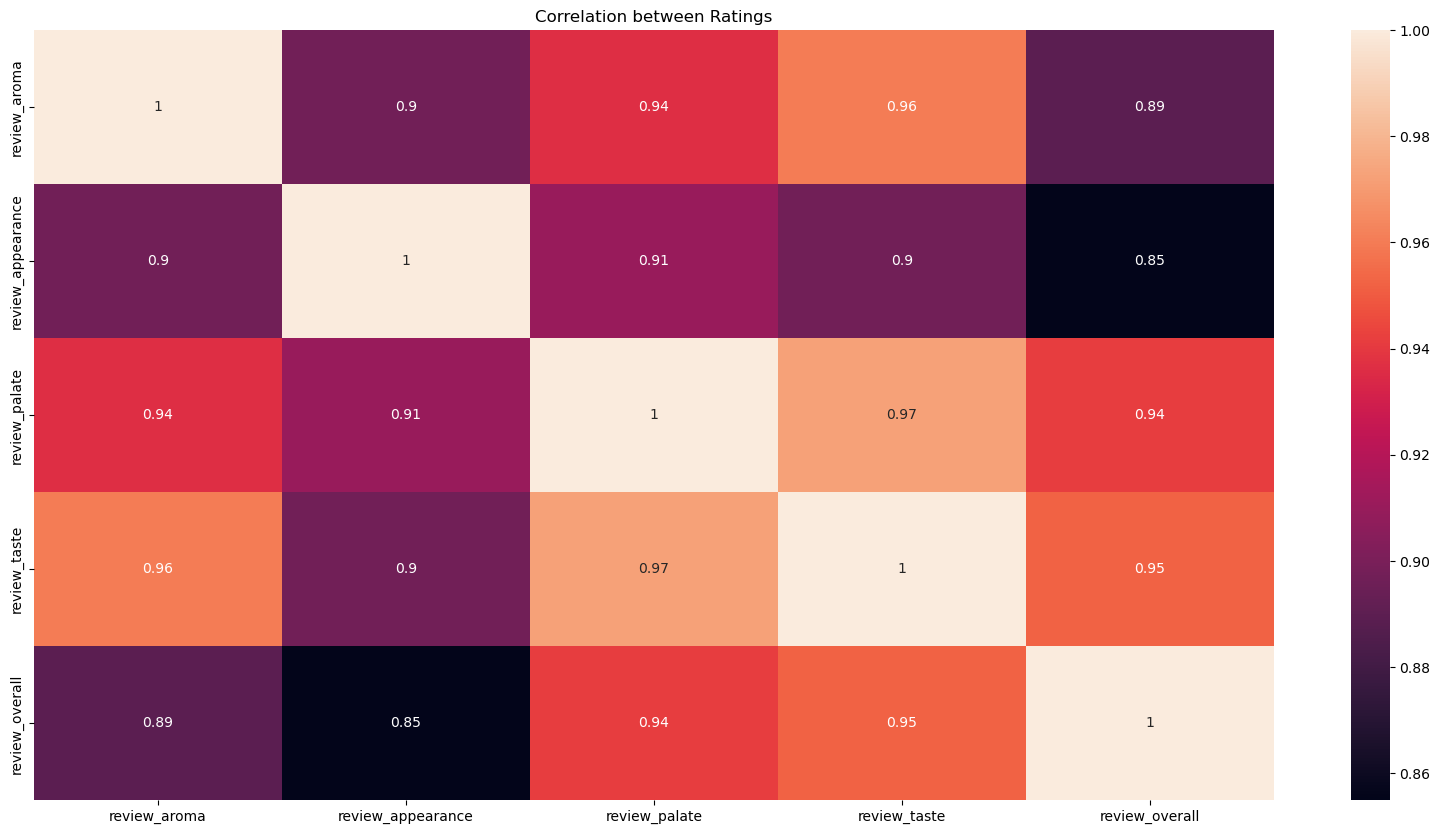

In [4]:
# there are multiple rating categories. Can we rely on the overall rating, or do ratings differ in the various categories?
# plot the distribution of ratings across the various categories
plt.figure(figsize=(20, 10))
sns.displot(data['review_aroma'], kde=False)
sns.displot(data['review_appearance'], kde=False)
sns.displot(data['review_palate'], kde=False)
sns.displot(data['review_taste'], kde=False)
sns.displot(data['review_overall'], kde=False)
plt.title('Distribution of Ratings across Categories')
plt.show()  # the distributions are very similar, so we should be able to rely on the overall rating. To be sure, lets plot the correlations

# plot the correlation matrix for all columns between review_aroma and review_overall to see whether the ratings are linearly correlated
plt.figure(figsize=(20, 10))
sns.heatmap(data.loc[:, ['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'review_overall']].corr(), annot=True)
plt.title('Correlation between Ratings') # very high correlations across the bank, so we can disregard the other rating categories


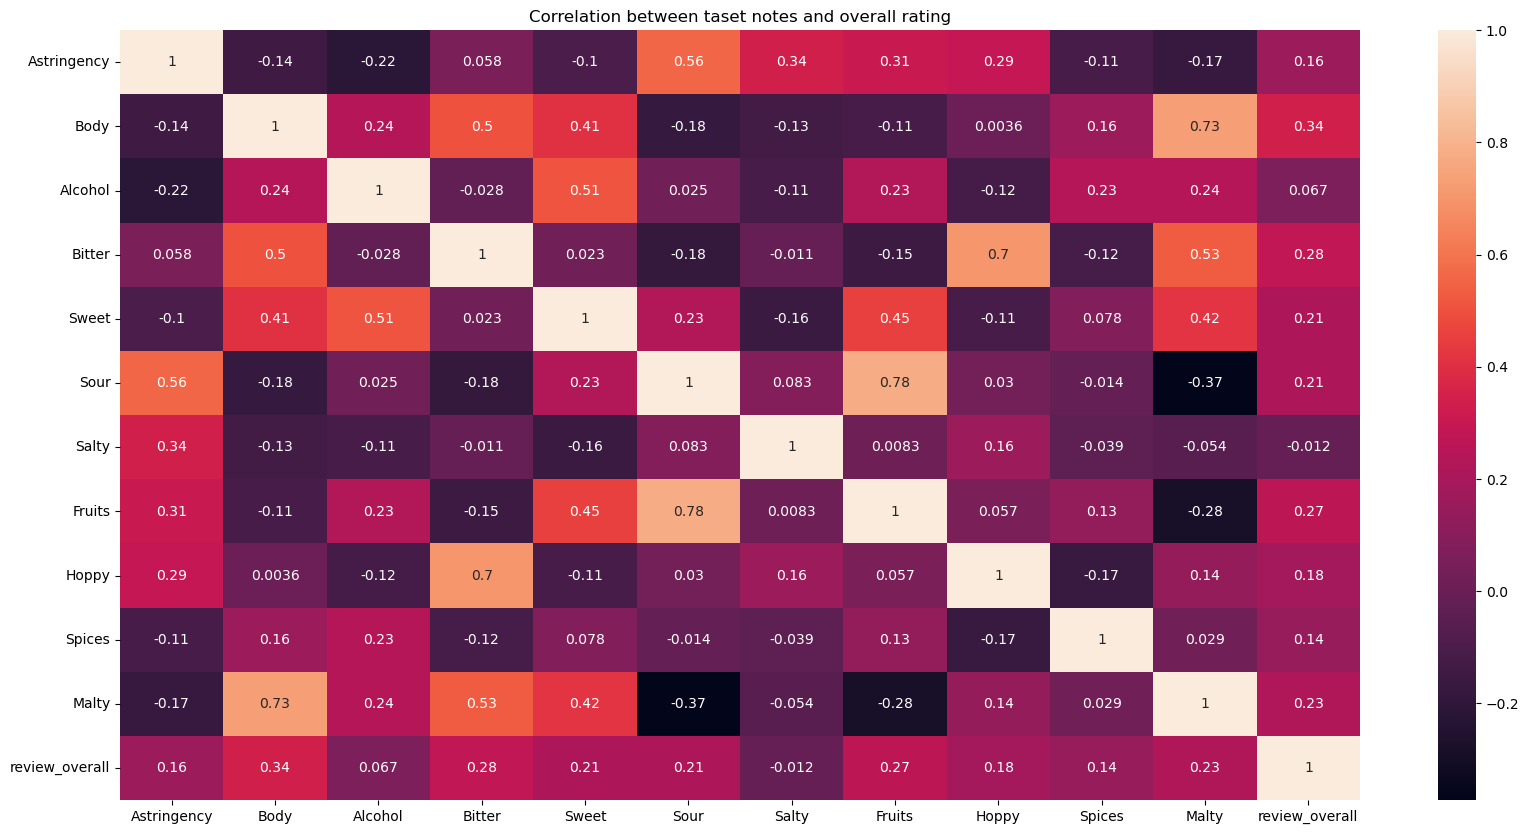

In [5]:
## Correlation analysis of the various taste notes
# plot correlation matrix for all columns between Astringency amd Malty and review_overall to see whether the ratings are linearly correlated with specific tast notes
plt.figure(figsize=(20, 10))
sns.heatmap(data.iloc[:, [8,
                          9,
                          10,
                          11,
                          12,
                          13,
                          14,
                          15,
                          16,
                          17,
                          18, 24]].corr(), annot=True)
plt.title('Correlation between taset notes and overall rating')
plt.show()  # it does not seem that there are specific taste notes that reviewers consistently relate to higher ratings


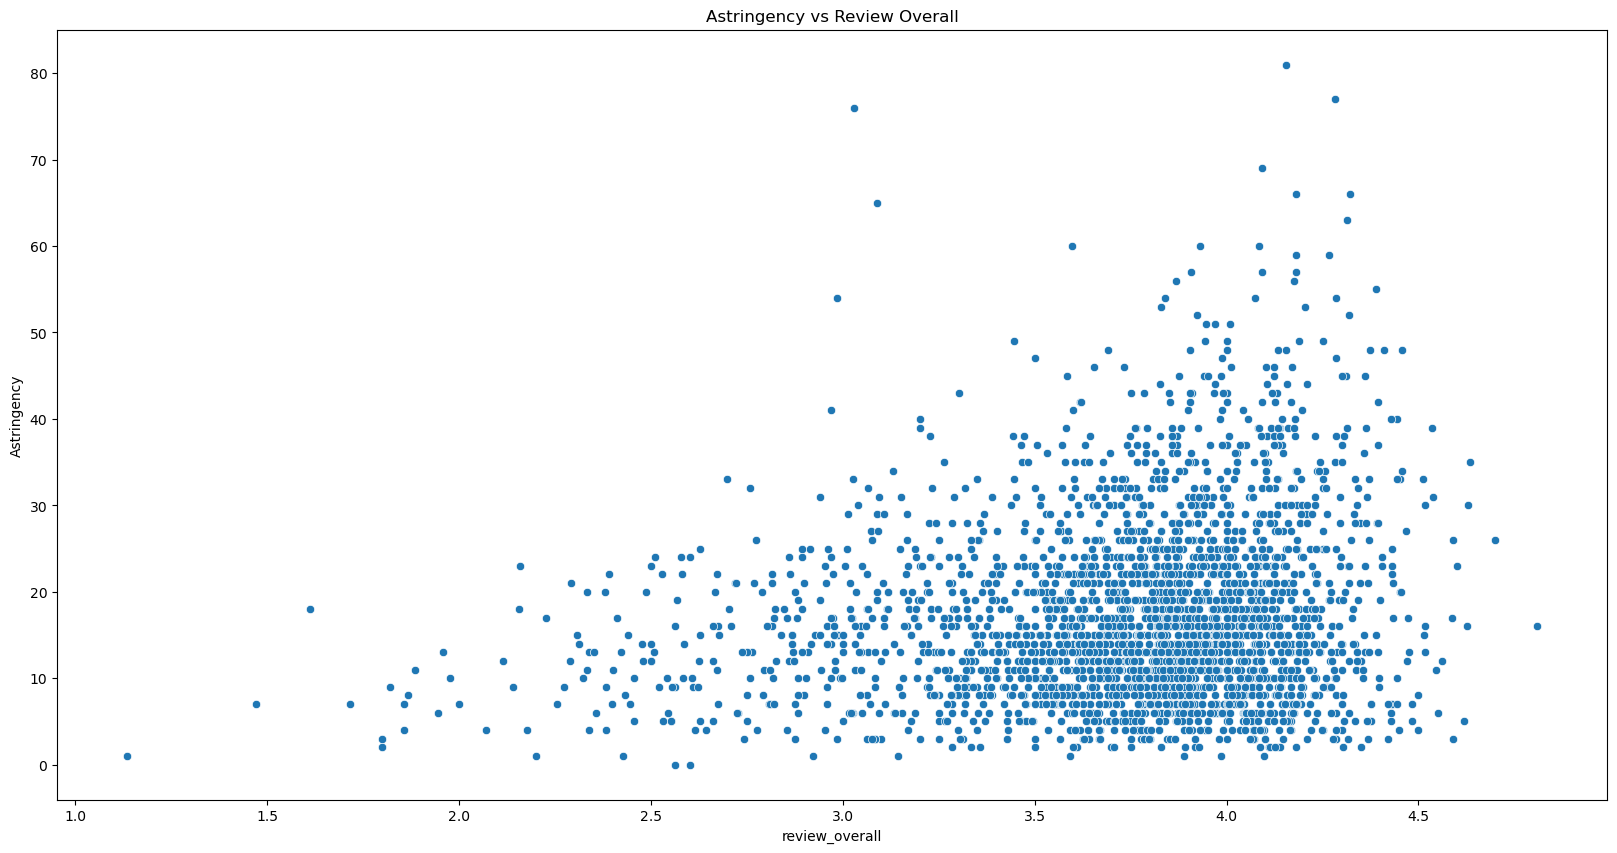

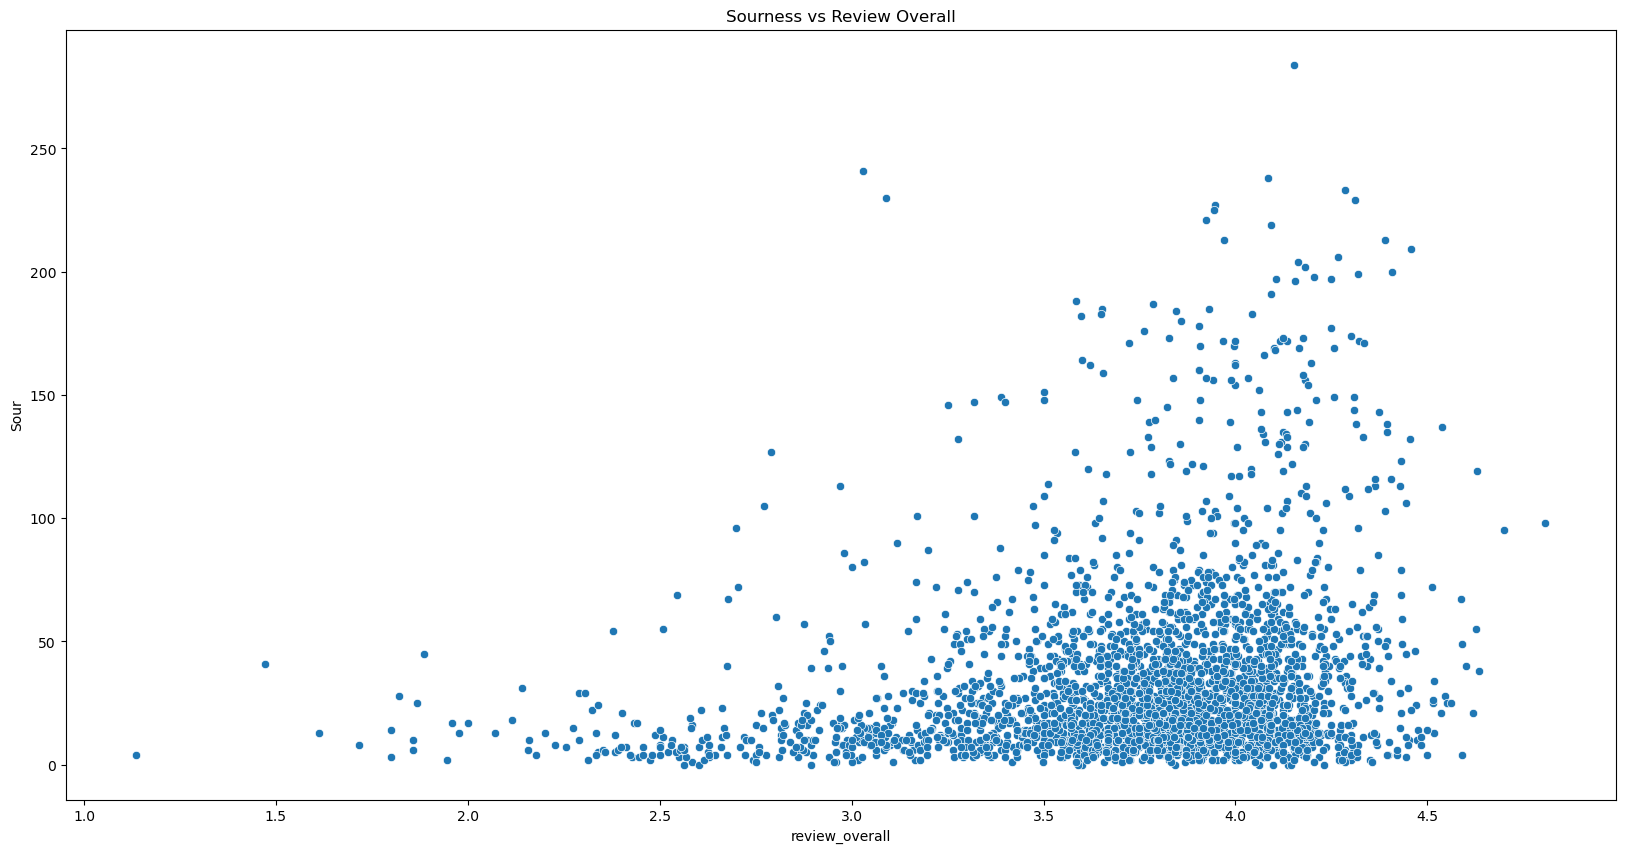

In [6]:
# How do individual taste notes correlate to the overall rating?
#plot the the datapoints for Astringency against review_overall to see whether there is a linear relationship
plt.figure(figsize=(20, 10))
sns.scatterplot(x='review_overall', y='Astringency', data=data)
plt.title('Astringency vs Review Overall')
plt.show()  # there is no linear relationship between Astringency and Review Overall, but good ratings are clustered around a certain range of astringency and the tail end of the distribution tends to correspond to higher values of this taste note

# Do the same for Sourness
plt.figure(figsize=(20, 10))
sns.scatterplot(x='review_overall', y='Sour', data=data)
plt.title('Sourness vs Review Overall')
plt.show() # similar behavior as Astringency



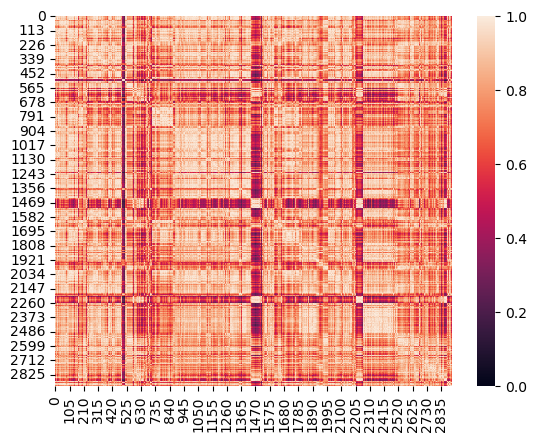

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,number_of_reviews,review_overall
258,Liberator Doppelbock,Bock - Doppelbock,Thomas Hooker Brewing Company,Thomas Hooker Brewing Company Thomas Hooker Li...,Notes:Hopped with German and Czech hops and fe...,8.5,17,27,5,63,...,45,40,9,114,4.139376,4.236842,4.260234,4.299220,513,4.230019
357,Winterbock,Bock - Traditional,Atwater Block Brewery,Atwater Block Brewery Atwater Winter Bock,Notes:,7.5,20,30,13,44,...,33,41,13,110,3.305556,3.722222,3.296296,3.074074,54,3.064815
274,Tucher Bajuvator Doppelbock,Bock - Doppelbock,Brauerei Tucher Brau,Brauerei Tucher Brau Tucher Bajuvator Doppelbock,Notes:,7.2,17,27,15,87,...,72,47,8,172,4.057377,4.032787,4.092896,4.169399,183,4.144809
1767,Old Jubilation,Old Ale,Avery Brewing Company,Avery Brewing Company Old Jubilation,Notes:,8.3,30,65,3,37,...,32,22,17,72,3.782303,3.986657,3.862360,3.917837,712,3.844101
273,Doppelbock Dunkel,Bock - Doppelbock,Brauerei Schloss Eggenberg,Brauerei Schloss Eggenberg Doppelbock Dunkel,Notes:,8.5,17,27,9,49,...,34,39,17,104,3.632479,3.803419,3.666667,3.709402,117,3.713675
3190,Winter Ale,Winter Warmer,St. Peter's Brewery Co Ltd,St. Peter's Brewery Co Ltd St. Peter's Winter Ale,Notes:This deep mahogany red strong ale is a c...,6.5,35,50,7,64,...,46,28,27,117,3.838415,3.829268,3.896341,3.951220,164,3.841463
266,Voodoovator,Bock - Doppelbock,Atwater Block Brewery,Atwater Block Brewery Atwater Voodoovator,Notes:,9.5,17,27,15,89,...,60,48,4,165,3.404494,3.752809,3.373596,3.292135,178,3.407303
1793,Lights Out Holiday Ale,Old Ale,Blue Mountain Brewery,Blue Mountain Brewery Lights Out Holiday Ale,Notes:,7.0,30,65,11,43,...,26,36,22,101,3.500000,3.729167,3.562500,3.604167,24,3.666667
2745,The Hairy Eyeball,Strong Ale - American,Lagunitas Brewing Company,Lagunitas Brewing Company Hairy Eyeball Ale,Notes:,9.1,40,100,11,58,...,30,41,8,101,3.772911,3.967655,3.880728,3.898922,742,3.774933
45,Old Numbskull,Barleywine - American,AleSmith Brewing Company,AleSmith Brewing Company AleSmith Old Numbskull,Notes:,11.0,60,100,14,58,...,54,67,13,122,4.176471,4.082633,4.137255,4.221289,357,4.102241


In [9]:
## Check which beer styles are most similar to each other
X = data.iloc[:, [8,
                  9,
                  10,
                  11,
                  12,
                  13,
                  14,
                  15,
                  16,
                  17,
                  18]]
cosine_sim = cosine_similarity(X, X)
indices = pd.Series(data.index, index=data['Name']).drop_duplicates()
# Visualize the similarity matrix
sns.heatmap(cosine_sim)
plt.show()

# based on the cosine similarity, we can now write a function that finds the 10 most similar beer styles to a beer of choice
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    beer_indices = [i[0] for i in sim_scores]
    return data.iloc[beer_indices]
# Lets try which beers are most similar to "Doppelsticke", a beer that I know and like (the brewery is in my homecity)
get_recommendations(title='Doppelsticke') #good recommendations. The beers all share a similar taste profile. 


 Lets recap: 
1. We have a dataset of 2914 beers with 24 features, of which 11 are taste notes
2. The data is linearly distributed across beer styles and log distributed across brewerie3. The ratings are linearly correlated across the bank, so we can disregard the other rating categories
4. The PCA shoes that while there are some underlying dimensions in the taset profiles, they are not meaningfully related to the beer styles or taste notes.
5. The cosine similarity shows that there are meaningful similarities between beer styles, which can be used to recommend similar beers to a beer of choice.
6. There is a pattern in how the various taste notes are distributed across the ratings, but it is not linearly correlated with the overall rating.

This makes it likely that a combination of taset profiles is related to better ratings. This could be a good starting point to predict the overall rating based on beer flavour profiles!
       